# <center>ディープラーニング入門</center>
# <center>セマンティック・セグメンテーションとUNet</center>



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. UNetの実装

Kerasを使えば（他のライブラリでもですが）UNetのようなモデルも短いコードで実装して学習させることができてとても便利です。

原論文は
https://arxiv.org/pdf/1505.04597.pdf
ですが、ネットにはたくさんの日本語資料があると思います。原論文ではConvのパディングはvaldのようですが、今回扱う実装はsame paddingにしてあります。

まず実装前に、UNetの構造を整理しましょう。UNetはConv二回とプーリング、そしてUpConvで構成されています。そこでまず部品として、Convを二回繰り返すブロックと、UpSamplingの後Convを行うUpConvブロックを関数として実装しておきましょう。

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def conv_block(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x)
    
    # Poolingでxを半分にした結果
    z = layers.MaxPooling2D((2,2))(x)

    return x, z

def upconv_block(inputs, n_channels=32):
    
    # Upsamplingでサイズを倍にした後、2x2 Convでチャネル数を変更。TransposeConvを使うのでも良い
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Conv2D(n_channels, (2,2), padding='same')(x)

    return x

UNet本体を作る関数を実装します。入力画像のサイズが引数size、Unetの「深さ」（Downsamplingのステップ数）がdepth、そしてセグメンテーションしなくてはならないカテゴリの数（「塗り絵」の黒以外の色数）がn_classesとします。


In [ ]:
def build_unet(size=(256,256,3), depth=4, n_classes=1):

    channels = [64 * 2**i for i in range(depth+1)]

    x_in = layers.Input(size)
    x = x_in

    downsampling_layers = []

    for c in channels[:-1]:
        x_unpool, x = conv_block(inputs=x, n_channels=c)
        downsampling_layers.append(x_unpool)

    x, _ = conv_block(inputs=x, n_channels=channels[-1])

    channels = channels[:-1][::-1]
    downsampling_layers = downsampling_layers[::-1]

    for i, c in enumerate(channels):
        x = upconv_block(inputs=x, n_channels=c)
        x = layers.Concatenate()([x, downsampling_layers[i]])
        x, _ = conv_block(inputs=x, n_channels=c)

    x = layers.Conv2D(n_classes, (1,1), padding='same', activation='sigmoid')(x)

    return Model(inputs=x_in, outputs=x)

愚直に実装しても良いですが、下流での層の出力を上流で再利用するので、layerの一部をリストの中に記録しながら下流からモデルを構築するように実装しました。

この実装で何をやっているかをパッと理解できない場合には、depth=1の場合のbuild_unet()がどうなっているのかを、ステップバイステップで丁寧に頭の中で追って見てください。functional APIで簡単なモデルが作れるようになった次には、他人の書いたもう少し込み入ったモデルのコードを読み解く訓練の段階に移ります。

- コメント：
この実装は入力サイズが一辺2**nの正方形でしか機能しないですし、深さが限界を超えないようにする制約も加えていません。もし時間のある方がいれば、一般的な状況でも使えるコードにするために改良を加えていただくと理解が深まると思います（ヒント：サイズの調整にClopなどを使う。画像が1x1以下には縮小させられないことから、可能なdepthの最大値を計算する。）

この関数でモデルが上手く作れるか確認して見ます：

In [ ]:
model = build_unet(size=(256,256,3), depth=4, n_classes=1)

In [ ]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 256, 256, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 256, 256, 64) 0           conv2d_114[0][0]                 
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 64) 36928       activation_96[0][0]              
_______________________________________________________________________________________

モデルの形状を可視化して確認しましょう：

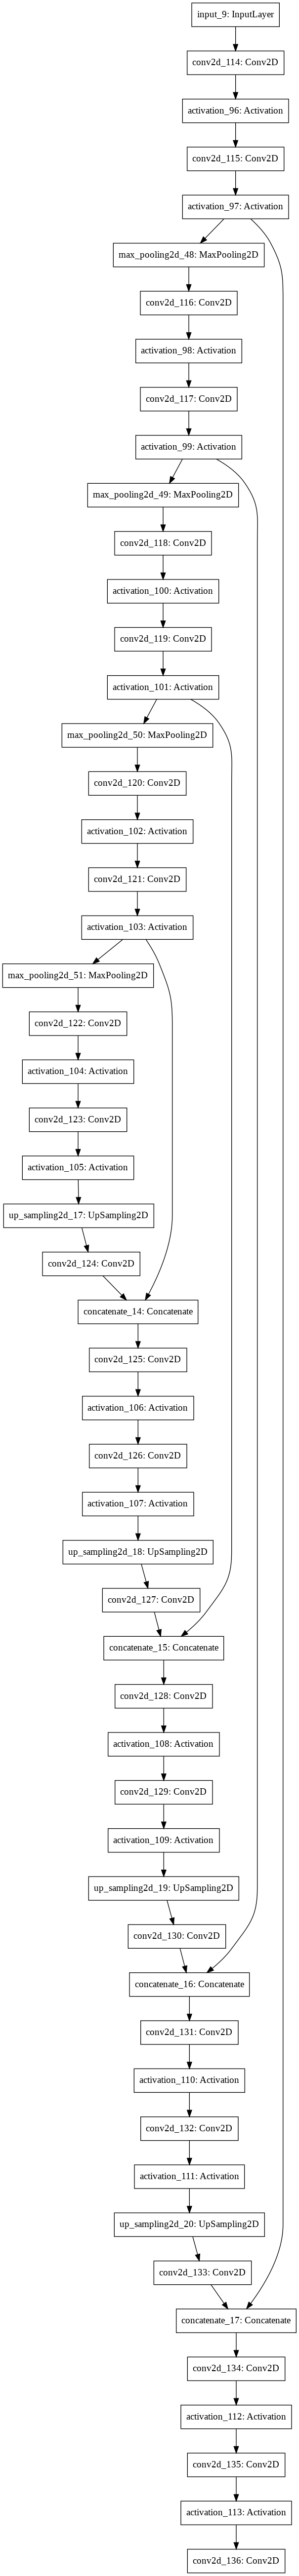

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(model)

## 2. データのダウンロード（肺のセグメンテーション）

日本放射線技術学会の提供しているデータのうち、Segmentation01というものを使ってみます。肺の単純X線写真から、肺の位置をセグメンテーションするためのデータです。以下のサイトで配布されています：

http://imgcom.jsrt.or.jp/minijsrtdb/

まずドライブをマウントしておきましょう：

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


データのzipファイルを、Google Driveの適当なところに落としておきます：

In [ ]:
!wget -P '/content/drive/My Drive' http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/12/Segmentation01_RGB.zip

--2020-09-23 09:52:35--  http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/12/Segmentation01_RGB.zip
Resolving imgcom.jsrt.or.jp (imgcom.jsrt.or.jp)... 158.199.228.161
Connecting to imgcom.jsrt.or.jp (imgcom.jsrt.or.jp)|158.199.228.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1869946 (1.8M) [application/zip]
Saving to: ‘/content/drive/My Drive/Segmentation01_RGB.zip’

Segmentation01_RGB. 100%[===================>]   1.78M   308KB/s    in 6.1s    

2020-09-23 09:52:41 (299 KB/s) - ‘/content/drive/My Drive/Segmentation01_RGB.zip’ saved [1869946/1869946]



解凍しておきます（どこかちゃんとしたデータセット用のディレクトリにでも置いて置いてください）：

In [ ]:
!unzip -d '/content/drive/My Drive' '/content/drive/My Drive/Segmentation01_RGB.zip'

Archive:  /content/drive/My Drive/Segmentation01_RGB.zip
  inflating: /content/drive/My Drive/Segmentation01_RGB/list_test.txt  
  inflating: /content/drive/My Drive/Segmentation01_RGB/list_train.txt  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/0.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/1.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/2.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/3.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/4.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/5.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/6.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/7.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/8.png  
  inflating: /content/drive/My Drive/Segmentation01_RGB/test/label/9.png  
  inflating: /content/drive/My Drive/Segmentatio

中身を見てみましょう。落としたファイルの中身は次のような感じで、このうちtrainというディレクトリの中の訓練データだけ使いましょう：

In [ ]:
!ls '/content/drive/My Drive/Segmentation01_RGB'

list_test.txt  list_train.txt  test  train


trainの中身は

In [ ]:
!ls '/content/drive/My Drive/Segmentation01_RGB/train'

img  label  org


となっており、origにX線写真、labelにセグメンテーションの絵（マスク）が入ってみます。

後々のために、それぞれのディレクトリにimgというフィルダを作りその中に全て画像を移しておきます：

In [ ]:
!mkdir '/content/drive/My Drive/Segmentation01_RGB/train/label/img'
!mkdir '/content/drive/My Drive/Segmentation01_RGB/train/org/img'

In [ ]:
import glob
import shutil

train_path = '/content/drive/My Drive/Segmentation01_RGB/train'

x_pathes = glob.glob('/content/drive/My Drive/Segmentation01_RGB/train' + '/org/*.png')
y_pathes = glob.glob('/content/drive/My Drive/Segmentation01_RGB/train' + '/label/*.png')

for path in x_pathes:
    shutil.move(path, '/content/drive/My Drive/Segmentation01_RGB/train/org/img')

for path in y_pathes:
    shutil.move(path, '/content/drive/My Drive/Segmentation01_RGB/train/label/img')

## 3. 画像の確認

In [ ]:
import glob

x_path = '/content/drive/My Drive/Segmentation01_RGB/train/org/img'
y_path = '/content/drive/My Drive/Segmentation01_RGB/train/label/img'

x_pathes = glob.glob(x_path + '/*.png')
y_pathes = glob.glob(y_path + '/*.png')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

img = load_img(path=x_pathes[0], target_size=(256,256), grayscale=True)
mask = load_img(path=y_pathes[0], target_size=(256,256), grayscale=True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


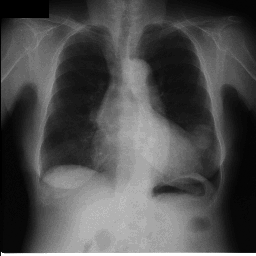

In [ ]:
img

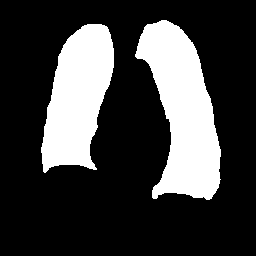

In [ ]:
mask

発展課題

- BatchNormalizationを入れてみる
- セグメンテーション用の面白いデータがあれば探す
- Pix2Pixのgenerator部分に採用されているUNet修正バージョンなどを理解・実装